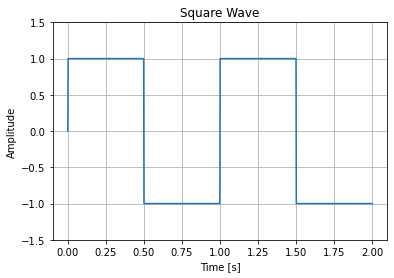

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
f0 = 1  # frequency of the square wave in Hz
t = np.linspace(0, 2, 1000)  # time array from 0 to 2 seconds

# Square wave function
square_wave = np.sign(np.sin(2 * np.pi * f0 * t))

# Plotting the square wave
plt.plot(t, square_wave)
plt.title('Square Wave')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.ylim([-1.5, 1.5])
plt.grid(True)
plt.show()


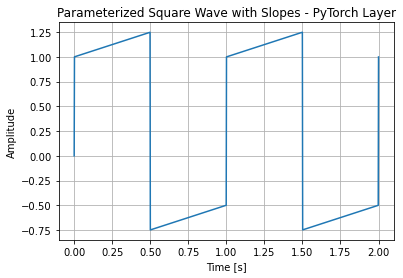

In [2]:
import torch
import torch.nn as nn

class ParamSquareWaveLayer(nn.Module):
    def __init__(self, frequency=1.0, slope=0.0):
        super(ParamSquareWaveLayer, self).__init__()
        self.frequency = frequency
        self.slope = slope

    def forward(self, t):
        # Compute the base square wave
        square_wave = torch.sign(torch.sin(2 * torch.pi * self.frequency * t))
        
        # Apply the slope to the flat parts
        # We'll use modulo to identify the flat sections of the square wave
        slope_correction = self.slope * (t % (1/self.frequency))
        
        # Apply the slope to the square wave
        square_wave_with_slope = square_wave + slope_correction
        
        return square_wave_with_slope

# Example usage
if __name__ == "__main__":
    # Create the parameterized square wave layer
    param_square_wave_layer = ParamSquareWaveLayer(frequency=1.0, slope=0.5)

    # Create a time tensor
    t = torch.linspace(0, 2, 1000)  # time from 0 to 2 seconds

    # Pass the time tensor through the square wave layer
    square_wave = param_square_wave_layer(t)

    # Plotting the result (optional)
    import matplotlib.pyplot as plt
    plt.plot(t.numpy(), square_wave.detach().numpy())
    plt.title('Parameterized Square Wave with Slopes - PyTorch Layer')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


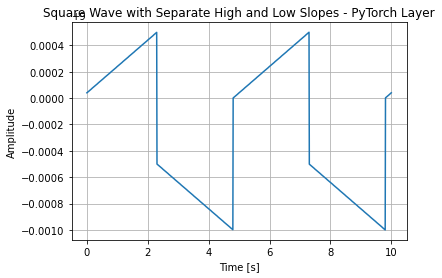

In [36]:
import torch
import torch.nn as nn

class DualSlopeSquareWaveLayer(nn.Module):
    def __init__(self, high_slope=0.0, low_slope=0.0):
        super(DualSlopeSquareWaveLayer, self).__init__()
        self.high_slope = high_slope
        self.low_slope = low_slope

    def forward(self, t):
        # Compute the base square wave
        square_wave = torch.sign(torch.sin(2 * torch.pi * t))
        
        
        # Identify high and low parts using the square wave values
        high_part = square_wave > 0
        low_part = square_wave < 0
        
        # Calculate the slope correction for high and low parts separately
        time_in_period = t % 1
        high_slope_correction = self.high_slope * time_in_period * high_part.float()
        low_slope_correction = self.low_slope * time_in_period * low_part.float()

        # Apply the slope correction
        square_wave_with_slope =  high_slope_correction + low_slope_correction
        
        return square_wave_with_slope

# Example usage
if __name__ == "__main__":
    # Create the parameterized square wave layer with separate slopes
    dual_slope_square_wave_layer = DualSlopeSquareWaveLayer( high_slope=1, low_slope=-1)

    # Create a time tensor
    t = torch.linspace(0, 10, 1000)  # time from 0 to 2 seconds

    # Pass the time tensor through the square wave layer
    square_wave = 0.001*dual_slope_square_wave_layer(t*0.2 + 0.04) +9

    # Plotting the result (optional)
    import matplotlib.pyplot as plt
    plt.plot(t.numpy(), square_wave.detach().numpy())
    plt.title('Square Wave with Separate High and Low Slopes - PyTorch Layer')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()


we need multiple of these square waves, all parameterized.  then we need to sum them up.  the next layer all needs to have the same t inputs.  

so ya, initial t is linear, and i think the next layer would have a lot of high frequency waves. i would guess hi frequency high slop waves.  then the next layer should take those and move them around, lower frequency, lower slopes.  i don't think we need mixing parameters, i think amplitude takes care of that.  yeah.  same thing lol.  

so yeah, fewer and lower frequency.  the lowest, or rather, a layer that is useless is one that is zoomed on onto on peak and has a slope of 1.  you can move that up or down with amplitude, left or right with phi.  

can phi train well with this? the derivatives are gonna be nice and simple, 
maybe thats just calculus but i'm struggling to conceptualize all the updating.  idk.  test.  

isolate those maybe? make them all correct and then let it learn one phi? thats a good idea.   i wonder if the derivative at the discontinuity is like, how you train phi.  like, you move that right? that is what phi is doing.  


In [93]:
class DualSlopeSquareWaveFunction(Function):
    @staticmethod
    def forward(ctx, t, high_slope, low_slope):
        # Save tensors for backward pass
        ctx.save_for_backward(t, high_slope, low_slope)
        
        # Compute the base square wave
        square_wave = torch.sign(torch.sin(2 * torch.pi * t))
        
        # Identify high and low parts using the square wave values
        high_part = (square_wave >= 0).float()
        low_part = (square_wave < 0).float()
        
        # Calculate the slope correction for high and low parts separately
        time_in_period = t % 1
        high_slope_correction = high_slope * time_in_period * high_part
        low_slope_correction = low_slope * time_in_period * low_part

        # Apply the slope correction
        square_wave_with_slope = high_slope_correction + low_slope_correction
        
        return square_wave_with_slope

    @staticmethod
    def backward(ctx, grad_output):
        t, high_slope, low_slope = ctx.saved_tensors
        
        # Initialize gradients
        grad_t = torch.zeros_like(t)
        grad_high_slope = torch.zeros_like(high_slope)
        grad_low_slope = torch.zeros_like(low_slope)
        
        # Compute the base square wave and sine
        sine_wave = torch.sin(2 * torch.pi * t)
        square_wave = torch.sign(sine_wave)
        
        # Identify high and low parts using the square wave values
        high_part = (square_wave > 0).float()
        low_part = (square_wave < 0).float()
        
        # Calculate the slope correction for high and low parts separately
        time_in_period = t % 1

        # Gradient w.r.t. t
        
        grad_t += high_slope * high_part * grad_output + low_slope * low_part * grad_output

        # Gradients w.r.t. high_slope and low_slope
        grad_high_slope = torch.sum(time_in_period * high_part * grad_output, dim=0)
        grad_low_slope = torch.sum(time_in_period * low_part * grad_output, dim=0)
        
        return grad_t, grad_high_slope, grad_low_slope


In [94]:
import torch
import torch.nn as nn

class DualSlopeSquareWaveLayer(nn.Module):
    def __init__(self, param_dim):
        super(DualSlopeSquareWaveLayer, self).__init__()
        # Initialize the parameters with torch.randn
        self.f = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.A = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.high_slope = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.low_slope = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.phi = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.param_dim = param_dim

    def forward(self, t):
        # Expand t to match param_dim
        t = t.unsqueeze(-1)  # Now t is [batch_size, 1]
       
    
        # Calculate the transformed t based on frequency, amplitude, and phase shift
        transformed_t = self.f * t + self.phi
        # Apply the DualSlopeSquareWaveFunction with the transformed t and slopes
        dual_slope_wave = DualSlopeSquareWaveFunction.apply
        output = dual_slope_wave(transformed_t, self.high_slope, self.low_slope)
        
        # Scale the output by the amplitude A
        output = self.A * output
        
        # Sum over the parameter dimension
        output = torch.sum(output, dim=-1)
        
        return output

# Example usage:
t = torch.linspace(0, 2, 100, requires_grad=True)  # Input is [batch_size]

# Initialize the layer with param_dim
param_dim = 10
layer = DualSlopeSquareWaveLayer(param_dim=param_dim)



In [98]:
import torch
from torch.autograd import Function


# Example usage:
t = torch.linspace(0, 2, 100, requires_grad=True).view(-1, 1)  # Input [batch_size, 1]

# Initialize the vectorized layer with param_dim
param_dim = 15
layer = DualSlopeSquareWaveLayer(param_dim=param_dim)

# Forward pass
output = layer(t)
print(output.shape)
# Backward pass
output.sum().backward()

# Check gradients
print(layer.f.grad.shape)
print(layer.A.grad.shape)
print(layer.high_slope.grad.shape)
print(layer.low_slope.grad.shape)
print(layer.phi.grad.shape)


torch.Size([100, 1])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])


In [101]:
import torch
import torch.nn as nn

class DualSlopeSquareWaveNetwork(nn.Module):
    def __init__(self, layer_dims):
        super(DualSlopeSquareWaveNetwork, self).__init__()
        
        # Create a list to hold the layers
        self.layers = nn.ModuleList()
        
        # Iterate through the list of layer dimensions and create layers
        for param_dim in layer_dims:
            layer = DualSlopeSquareWaveLayer(param_dim=param_dim)
            self.layers.append(layer)
    
    def forward(self, t):
        # Pass the input t through each layer sequentially
        for layer in self.layers:
            t = layer(t)
        return t

# Example usage:
t = torch.linspace(0, 2, 100, requires_grad=True)  # Input [batch_size]

# Define the network with specified layer dimensions
layer_dims = [10, 10, 20, 5, 1]
network = DualSlopeSquareWaveNetwork(layer_dims=layer_dims)

# Forward pass through the network
output = network(t)
print(output.shape)
# Backward pass



torch.Size([100])
